Using device: cuda
Number of GPUs available: 2


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Using DataParallel for multi-GPU training.



Number of training samples: 170191
Number of evaluation samples: 18911
Total number of sentences in training data: 340382
Total number of sentences in evaluation data: 37822


Map:   0%|          | 0/18911 [00:00<?, ? examples/s]

Starting training...


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch [1/4], Step [0/5319], Loss: 8.7758
Epoch [1/4], Step [1000/5319], Loss: 3.2906
Epoch [1/4], Step [2000/5319], Loss: 2.7521
Epoch [1/4], Step [3000/5319], Loss: 2.4591
Epoch [1/4], Step [4000/5319], Loss: 2.2671
Epoch [1/4], Step [5000/5319], Loss: 2.1316
Epoch [1/4], Evaluation BLEU Score: 49.90
Epoch [2/4], Step [0/5319], Loss: 1.5474
Epoch [2/4], Step [1000/5319], Loss: 1.4240
Epoch [2/4], Step [2000/5319], Loss: 1.3788
Epoch [2/4], Step [3000/5319], Loss: 1.3612
Epoch [2/4], Step [4000/5319], Loss: 1.3383
Epoch [2/4], Step [5000/5319], Loss: 1.3202
Epoch [2/4], Evaluation BLEU Score: 55.29
Epoch [3/4], Step [0/5319], Loss: 1.0143
Epoch [3/4], Step [1000/5319], Loss: 1.1406
Epoch [3/4], Step [2000/5319], Loss: 1.1318
Epoch [3/4], Step [3000/5319], Loss: 1.1204
Epoch [3/4], Step [4000/5319], Loss: 1.1158
Epoch [3/4], Step [5000/5319], Loss: 1.1053
Epoch [3/4], Evaluation BLEU Score: 57.46
Epoch [4/4], Step [0/5319], Loss: 1.0129
Epoch [4/4], Step [1000/5319], Loss: 1.0277
Epoch 

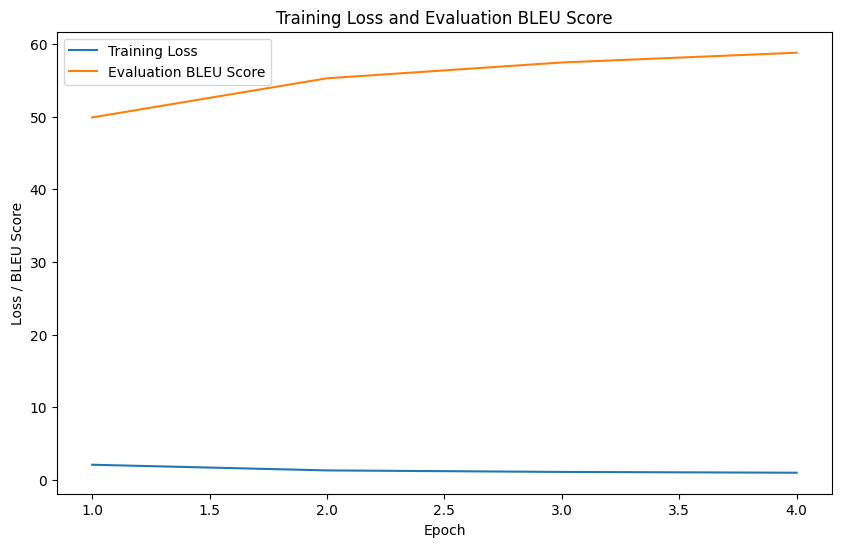

Generating predictions on the test set...
Computing BLEU scores for each test sample...


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


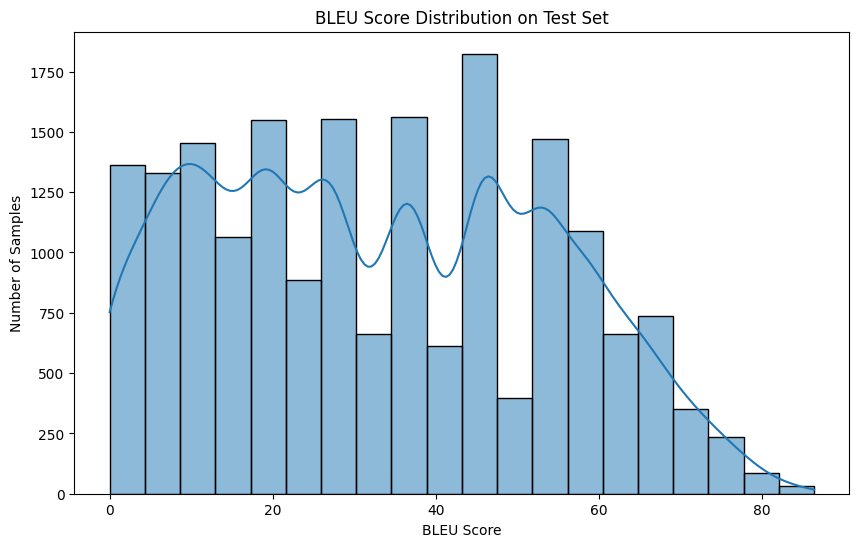

Average BLEU score on test set: 33.06

Sample translations from the test set:

Source: how cold will it be today ?
Reference: aj kitni thandi hone wali hai ?
Prediction: aj kitni thandi hone wali hai ?

Source: remind me to pick up prescription
Reference: prescription lene ke liye mujhe yad dilaen
Prediction: mujhe prescription lene ke liye yaad dilaye

Source: Change 9 am alarm to 9 : 30 am
Reference: 9 am ke alarm ko 9 : 30 am me badle
Prediction: 9 am ke alarm ko 9 : 30 am me badle

Source: Would I be able to take the kids to the park tomorrow ?
Reference: kya mai kal bacchon ko park me le jaunga ?
Prediction: kya mai kal park me bacchon ko le jaunga ?

Source: timer start
Reference: timer ko start karo
Prediction: timer ko start karo

Custom Translation:
Input: I was waiting for my bag
Translated Output: mai mere bag ke liye waiting kar raha hoon


In [1]:
# Install necessary packages
!pip install transformers datasets sacrebleu sentencepiece evaluate

# Import necessary libraries
import os
import torch
import datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from evaluate import load as load_metric
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
)
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
import random

# Set environment variable to disable parallelism in tokenizers
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Check if GPUs are available and set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    n_gpu = torch.cuda.device_count()
    print(f"Using device: {device}")
    print(f"Number of GPUs available: {n_gpu}")
else:
    device = torch.device("cpu")
    n_gpu = 0
    print("No GPU available, using CPU.")

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if n_gpu > 0:
    torch.cuda.manual_seed_all(seed)

# Initialize model, tokenizer, and config
model_name = "facebook/bart-base"  # Changed from "t5-small" to "facebook/bart-base"
config = AutoConfig.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    use_fast=True,
)
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    config=config)

# Move model to device before wrapping with DataParallel
model.to(device)

# Wrap the model with DataParallel
if n_gpu > 1:
    model = torch.nn.DataParallel(model)
    print("Using DataParallel for multi-GPU training.")

# Load the dataset
dataset = load_dataset('findnitai/english-to-hinglish')

# 100%
sample_fraction = 1
dataset = dataset['train'].shuffle(seed=seed).select(range(int(len(dataset['train']) * sample_fraction)))
dataset = datasets.DatasetDict({'train': dataset})

# Prepare tokenizer with additional data
master = []
for line in dataset['train']['translation']:
    master.append(line['en'])
    master.append(line['hi_ng'])

def gen_training_data():
    return (master[i : i+500]
            for i in range(0, len(master), 500)
           )

tokenizer_training_data = gen_training_data()
tokenizer = tokenizer.train_new_from_iterator(tokenizer_training_data, 32128)

# Split the dataset into train and test
raw_datasets = dataset['train'].train_test_split(test_size=0.1, seed=seed)
train_dataset = raw_datasets['train']
eval_dataset = raw_datasets['test']

# Print number of sentences in the datasets
num_train_samples = len(train_dataset)
num_eval_samples = len(eval_dataset)

total_train_sentences = num_train_samples * 2  # Each sample has an English and a Hinglish sentence
total_eval_sentences = num_eval_samples * 2

print(f"Number of training samples: {num_train_samples}")
print(f"Number of evaluation samples: {num_eval_samples}")
print(f"Total number of sentences in training data: {total_train_sentences}")
print(f"Total number of sentences in evaluation data: {total_eval_sentences}")

# Preprocessing parameters
# source_prefix = "translate English to Hinglish: "  # Removed for BART
source_lang = "en"
target_lang = "hi_ng"
max_source_length = 128
max_target_length = 128
padding = "max_length"
num_epochs = 4

# Preprocessing function
def preprocess_function(examples):
    inputs = [ex[source_lang] for ex in examples['translation']]
    targets = [ex[target_lang] for ex in examples['translation']]
    # inputs = [source_prefix + inp for inp in inputs]  # Removed for BART
    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)
    labels = tokenizer(targets, max_length=max_target_length, padding=padding, truncation=True)
    # Replace padding token ids with -100 to ignore in loss computation
    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
    ]
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply preprocessing to datasets
train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=["translation"])
eval_dataset = eval_dataset.map(preprocess_function, batched=True, remove_columns=["translation"])

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding=True)

# Create DataLoaders
per_device_train_batch_size = 32  # Increase batch size to utilize GPU memory
per_device_eval_batch_size = 16

train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=data_collator, batch_size=per_device_train_batch_size)
eval_dataloader = DataLoader(eval_dataset, collate_fn=data_collator, batch_size=per_device_eval_batch_size)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)

num_update_steps_per_epoch = len(train_dataloader)
max_train_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=max_train_steps
)

# Metric
metric = load_metric('sacrebleu')

# Function to postprocess text
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels

# Training loop
total_train_loss = []
total_eval_bleu = []

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for step, batch in enumerate(train_dataloader):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)
        loss = outputs.loss  # Loss is a tensor with size [num_gpus]
        
        # Aggregate the loss
        loss_value = loss.mean().item()
        epoch_train_loss += loss_value
        
        # Backward pass on the mean loss
        loss.mean().backward()
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        if step % 1000 == 0:
            current_loss = epoch_train_loss / (step + 1)
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step}/{len(train_dataloader)}], Loss: {current_loss:.4f}")
    
    avg_train_loss = epoch_train_loss / len(train_dataloader)
    total_train_loss.append(avg_train_loss)
    
    # Evaluate at the end of each epoch
    model.eval()
    all_preds = []
    all_labels = []
    for step, batch in enumerate(eval_dataloader):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            if n_gpu > 1:
                generated_tokens = model.module.generate(
                    batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    max_length=max_target_length,
                    num_beams=4,
                )
            else:
                generated_tokens = model.generate(
                    batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    max_length=max_target_length,
                    num_beams=4,
                )
        labels = batch["labels"]
        
        labels = labels.cpu().numpy()
        generated_tokens = generated_tokens.cpu().numpy()
        
        # Replace -100 with pad_token_id
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        
        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        
        decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
        
        all_preds.extend(decoded_preds)
        all_labels.extend(decoded_labels)
    
    result = metric.compute(predictions=all_preds, references=all_labels)
    eval_bleu = result["score"]
    print(f"Epoch [{epoch+1}/{num_epochs}], Evaluation BLEU Score: {eval_bleu:.2f}")
    total_eval_bleu.append(eval_bleu)

print("Training completed.")

# Plot training loss and evaluation BLEU score
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), total_train_loss, label='Training Loss')
plt.plot(range(1, num_epochs+1), total_eval_bleu, label='Evaluation BLEU Score')
plt.xlabel('Epoch')
plt.ylabel('Loss / BLEU Score')
plt.title('Training Loss and Evaluation BLEU Score')
plt.legend()
plt.show()

# Generate predictions on the test set
print("Generating predictions on the test set...")
model.eval()
all_preds = []
all_labels = []
for step, batch in enumerate(eval_dataloader):
    # Move batch to device
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        if n_gpu > 1:
            generated_tokens = model.module.generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_length=max_target_length,
                num_beams=4,
            )
        else:
            generated_tokens = model.generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_length=max_target_length,
                num_beams=4,
            )
    labels = batch["labels"]
    
    labels = labels.cpu().numpy()
    generated_tokens = generated_tokens.cpu().numpy()
    
    # Replace -100 with pad_token_id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    
    decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    
    all_preds.extend(decoded_preds)
    all_labels.extend(decoded_labels)

# Compute individual BLEU scores
print("Computing BLEU scores for each test sample...")
individual_bleu_scores = []
for pred, label in zip(all_preds, all_labels):
    bleu = metric.compute(predictions=[pred], references=[[label]])
    individual_bleu_scores.append(bleu['score'])

# Plot BLEU score distribution
plt.figure(figsize=(10, 6))
sns.histplot(individual_bleu_scores, bins=20, kde=True)
plt.title('BLEU Score Distribution on Test Set')
plt.xlabel('BLEU Score')
plt.ylabel('Number of Samples')
plt.show()

# Print average BLEU score
average_bleu = np.mean(individual_bleu_scores)
print(f"Average BLEU score on test set: {average_bleu:.2f}")

# Sample translations
print("\nSample translations from the test set:")
for i in range(5):
    input_ids = eval_dataset[i]['input_ids']
    input_text = tokenizer.decode(input_ids, skip_special_tokens=True)
    print(f"\nSource: {input_text}")  # Removed source_prefix
    print(f"Reference: {all_labels[i][0]}")
    print(f"Prediction: {all_preds[i]}")

# Function to translate new sentences
def translate_sentence(sentence):
    # input_text = source_prefix + sentence  # Removed source_prefix
    input_text = sentence  # Direct input for BART
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        if n_gpu > 1:
            generated_tokens = model.module.generate(input_ids, max_length=max_target_length, num_beams=4)
        else:
            generated_tokens = model.generate(input_ids, max_length=max_target_length, num_beams=4)
    translated_text = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
    return translated_text

# Test the model with a custom sentence
custom_sentence = "I was waiting for my bag"
translated_sentence = translate_sentence(custom_sentence)
print("\nCustom Translation:")
print(f"Input: {custom_sentence}")
print(f"Translated Output: {translated_sentence}")
